# Graphs for Paper

This note book relies on the note books and scripts to be ran to generate the training data for the different experiments.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image

import numpy as np
from scipy.stats import entropy

width = 64
height = 64
channels = 3


if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
    #generator.cuda()
    #discriminator.cuda()
    #adversarial_loss.cuda()
    Tensor = torch.cuda.FloatTensor
    print(device)

cuda:0


In [2]:
class GeneratorCIFAR(nn.Module):
    def __init__(self, latent_dim, width, channels, n_classes):
        super(GeneratorCIFAR, self).__init__()
        self.n_classes = n_classes
        # First, transform the input into a 8x8 256-channels feature map
        self.init_size = width // 16  # one 16th the image size 
        self._latent_dim = latent_dim
        self.l1 = nn.Sequential(
            nn.Linear(self._latent_dim + n_classes, 64), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 128), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256 * self.init_size ** 2), nn.LeakyReLU(0.2, inplace=True), # 4X4
        )
        
        self.conv_blocks = nn.Sequential(
            #input 256 X init_size X init_size
            
            ############# 4x4 #########################################
            
            nn.BatchNorm2d(256), 
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), #8X8
            nn.LeakyReLU(0.2, inplace=True),
            
            ############# 8X8 #########################################
            
            nn.BatchNorm2d(128), 
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            
            ############# 16X16 #########################################
            
            nn.BatchNorm2d(64), 
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), #32X32
            nn.LeakyReLU(0.2, inplace=True),
            
            ############# 32X32 #########################################
            
            nn.BatchNorm2d(32), 
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1), #64X64
            nn.LeakyReLU(0.2, inplace=True),
            
            ############# 64X64 #########################################
            
            # Produce a 32x32xRGB-channel feature map
            nn.Conv2d(16, channels, kernel_size=3, padding='same'),
            nn.Tanh(),
        )
        
    def forward(self, z, classes):
        
        z = torch.cat((z, classes), dim=1)
        # expand the sampled z to 8x8
        out = self.l1(z)
        
        out = torch.reshape(out, (out.shape[0], 256, self.init_size, self.init_size))
        
        # use the view function to reshape the layer output
        #  old way for earlier Torch versions: out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [3]:
class DiscriminatorCIFAR(nn.Module):

    def __init__(self, latent_dim, width, channels, n_classes):
        super(DiscriminatorCIFAR, self).__init__()
        
        self.init_size = width // 16 # one 16th the image size 
        self._latent_dim = latent_dim
        self.n_classes = n_classes
        self.model = nn.Sequential(
            
            ############# 64X64 #########################################
            nn.Conv2d(in_channels=channels, out_channels=16, kernel_size=3, stride=1, padding='same'), #64X64
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(16, 0.8),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1), #32X32
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32, 0.8),
            
            ############# 32X32 #########################################
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64, 0.8),
            
            ############# 16X16 #########################################
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1), #8x8
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128, 0.8),
            
            ############# 8X8 #########################################
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1), #4X4
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256, 0.8),
            
            ############# 4x4 #########################################
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256, 0.8),
        )
        
        # laten_dim_layer layer
        self.laten_dim_layer = nn.Sequential(nn.Linear(256 * self.init_size ** 2 + n_classes, 128), nn.LeakyReLU(0.2, inplace=True),
                                             nn.Linear(128, 64), nn.LeakyReLU(0.2, inplace=True),
                                             nn.Linear(64, self._latent_dim), nn.LeakyReLU(0.2, inplace=True),
                                            )
        # Classification layer
        self.classification_layer = nn.Sequential(nn.Linear(self._latent_dim + n_classes, 1), 
                                                  nn.Sigmoid())
    def get_feature_layer_1(self, img):
        
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = self.model(img)
        return out
    def get_feature_layer_2(self, img, classes):
        
        # move to the latent dim
        out = self.get_feature_layer_1(img)
        out = torch.flatten(out, start_dim=1)
        out = torch.cat((out, classes), dim=1)
        out = self.laten_dim_layer(out)
        return out 
    def forward(self, img, classes):
        
        out = self.get_feature_layer_2(img, classes)
        out = torch.cat((out, classes), dim=1)
        validity = self.classification_layer(out)
        return validity


In [6]:
def load_checkpoint(file_prefix, gen_func, disc_func, gan_folder='gan_models'):
    # load up checkpoint images from previous runs ls_images_dog.npy
    ims = np.load(f'models/{gan_folder}/{file_prefix}_images_celeb.npy')

    #np.save(f'models/gan_models/{setback_name}_is_scores_celeb.npy', IS_scores)
    is_score = np.load(f'models/{gan_folder}/{file_prefix}_is_scores_celeb.npy')
    
    generator = gen_func(100,32,3,6) # create generator (no weights)
    discriminator = disc_func(100,32,3,6) # create disciminator (no weights)

    # now populate the weights from a previous training
    print(f'models/{gan_folder}/{file_prefix}_gen.pth')
    checkpoint = torch.load(f'models/{gan_folder}/{file_prefix}_gen_celeb.pth')
    generator.load_state_dict(checkpoint['state_dict'])

    checkpoint = torch.load(f'models/{gan_folder}/{file_prefix}_dis_celeb.pth')
    discriminator.load_state_dict(checkpoint['state_dict'])
    
    return ims, generator, discriminator, is_score

In [7]:
def plot_is_score(scores_labels):

    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
    plt.figure(figsize=(12.8,4.8))
    for i, (score, label) in enumerate(scores_labels):
        epochs = range(1, len(score) + 1)
        plt.plot(epochs,  score, colors[i], label=f'Inception Score: {label}', )
    plt.title('Inception*')
    plt.legend()
    plt.show()

In [8]:
ims_ls, gen_ls, disc_ls, is_score_ls = load_checkpoint('ls', GeneratorCIFAR, DiscriminatorCIFAR, gan_folder='gan_models_CIFAR_no_fm_final')
ims_sb50_25, gen_sb50_25, disc_sb50_25, is_score_sb50_25 = load_checkpoint('setback_50_0.25', GeneratorCIFAR, DiscriminatorCIFAR, gan_folder='gan_models_CIFAR_no_fm_final')
ims_sb50_50, gen_sb50_50, disc_sb50_50, is_score_sb50_50 = load_checkpoint('setback_50_0.5', GeneratorCIFAR, DiscriminatorCIFAR, gan_folder='gan_models_CIFAR_no_fm_final')
ims_sb50_75, gen_sb50_75, disc_sb50_75, is_score_sb50_75 = load_checkpoint('setback_50_0.75', GeneratorCIFAR, DiscriminatorCIFAR, gan_folder='gan_models_CIFAR_no_fm_final')
ims_sb100_25, gen_sb100_25, disc_sb100_25, is_score_sb100_25 = load_checkpoint('setback_100_0.25', GeneratorCIFAR, DiscriminatorCIFAR, gan_folder='gan_models_CIFAR_no_fm_final')
ims_sb100_50, gen_sb100_50, disc_sb100_50, is_score_sb100_50 = load_checkpoint('setback_100_0.5', GeneratorCIFAR, DiscriminatorCIFAR, gan_folder='gan_models_CIFAR_no_fm_final')
ims_sb100_75, gen_sb100_75, disc_sb100_75, is_score_sb100_75 = load_checkpoint('setback_100_0.75', GeneratorCIFAR, DiscriminatorCIFAR, gan_folder='gan_models_CIFAR_no_fm_final')


models/gan_models_CIFAR_no_fm_final/ls_gen.pth
models/gan_models_CIFAR_no_fm_final/setback_50_0.25_gen.pth
models/gan_models_CIFAR_no_fm_final/setback_50_0.5_gen.pth
models/gan_models_CIFAR_no_fm_final/setback_50_0.75_gen.pth
models/gan_models_CIFAR_no_fm_final/setback_100_0.25_gen.pth
models/gan_models_CIFAR_no_fm_final/setback_100_0.5_gen.pth
models/gan_models_CIFAR_no_fm_final/setback_100_0.75_gen.pth


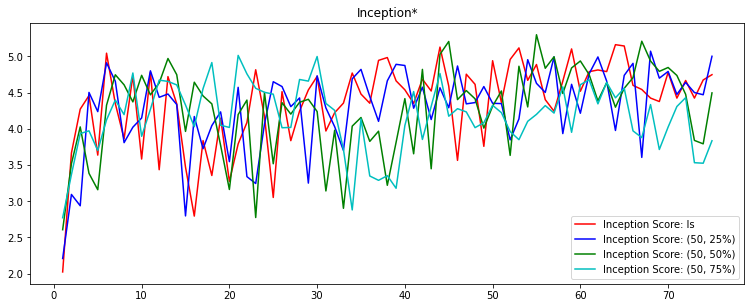

In [9]:
plot_is_score(
    [
        (is_score_ls[:,0], 'ls'),
        (is_score_sb50_25[:,0], '(50, 25%)'),
        (is_score_sb50_50[:,0], '(50, 50%)'),
        (is_score_sb50_75[:,0], '(50, 75%)'),
        #(is_score_sb100_25, '(100, 25%)'),
        #(is_score_sb100_50, '(100, 50%)'),
        #(is_score_sb100_75, '(100, 75%)')
    ])

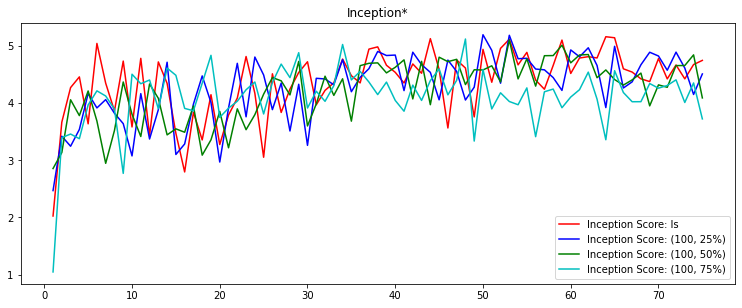

In [10]:
plot_is_score(
    [
        (is_score_ls[:,0], 'ls'),
        #(is_score_sb50_25[:,0], '(50, 25%)'),
        #(is_score_sb50_50[:,0], '(50, 50%)'),
        #(is_score_sb50_75[:,0], '(50, 75%)'),
        (is_score_sb100_25[:,0], '(100, 25%)'),
        (is_score_sb100_50[:,0], '(100, 50%)'),
        (is_score_sb100_75[:,0], '(100, 75%)')
    ])

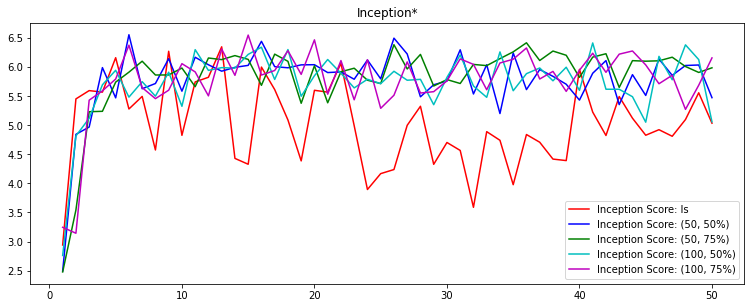

In [31]:
plot_is_score(
    [
        (is_score_ls[:,0], 'ls'),
        #(is_score_sb50_25[:,0], '(50, 25%)'),
        (is_score_sb50_50[:,0], '(50, 50%)'),
        (is_score_sb50_75[:,0], '(50, 75%)'),
        #(is_score_sb100_25[:,0], '(100, 25%)'),
        (is_score_sb100_50[:,0], '(100, 50%)'),
        (is_score_sb100_75[:,0], '(100, 75%)')
    ])

In [11]:
def norm_grid(im):
    # first half should be normalized and second half also, separately
    im = im.astype(np.float)
    rows,cols,chan = im.shape
    cols_over2 = int(cols/2)
    tmp = im[:,:cols_over2,:]
    im[:,:cols_over2,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    tmp = im[:,cols_over2:,:]
    im[:,cols_over2:,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    return im

In [19]:
def imshow(img, title=''):
    # custom show in order to display
    # torch tensors as numpy
    npimg = img.numpy() / 2 + 0.5 # from tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title, fontsize=100)
    plt.axis('off')
    plt.show()
    
def plot_100(generator, random_latent_vectors=None, random_classes=None, count=100, title=''):
    # Sample Vectors
    latent_dim = 100
    if random_latent_vectors is None:
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (100, latent_dim)))).detach().cpu()
    
    if random_classes is None:
        random_classes = Variable(Tensor(np.eye(6)[np.random.choice(6, 100)])).detach().cpu()
    # Generate images from sampled vectors
    gen_ims_ls = generator(random_latent_vectors,random_classes)

    plt.figure(figsize=(40,40))
    imshow(torchvision.utils.make_grid(gen_ims_ls[0:100], padding=2, normalize=False, nrow=10).cpu(), title=title)

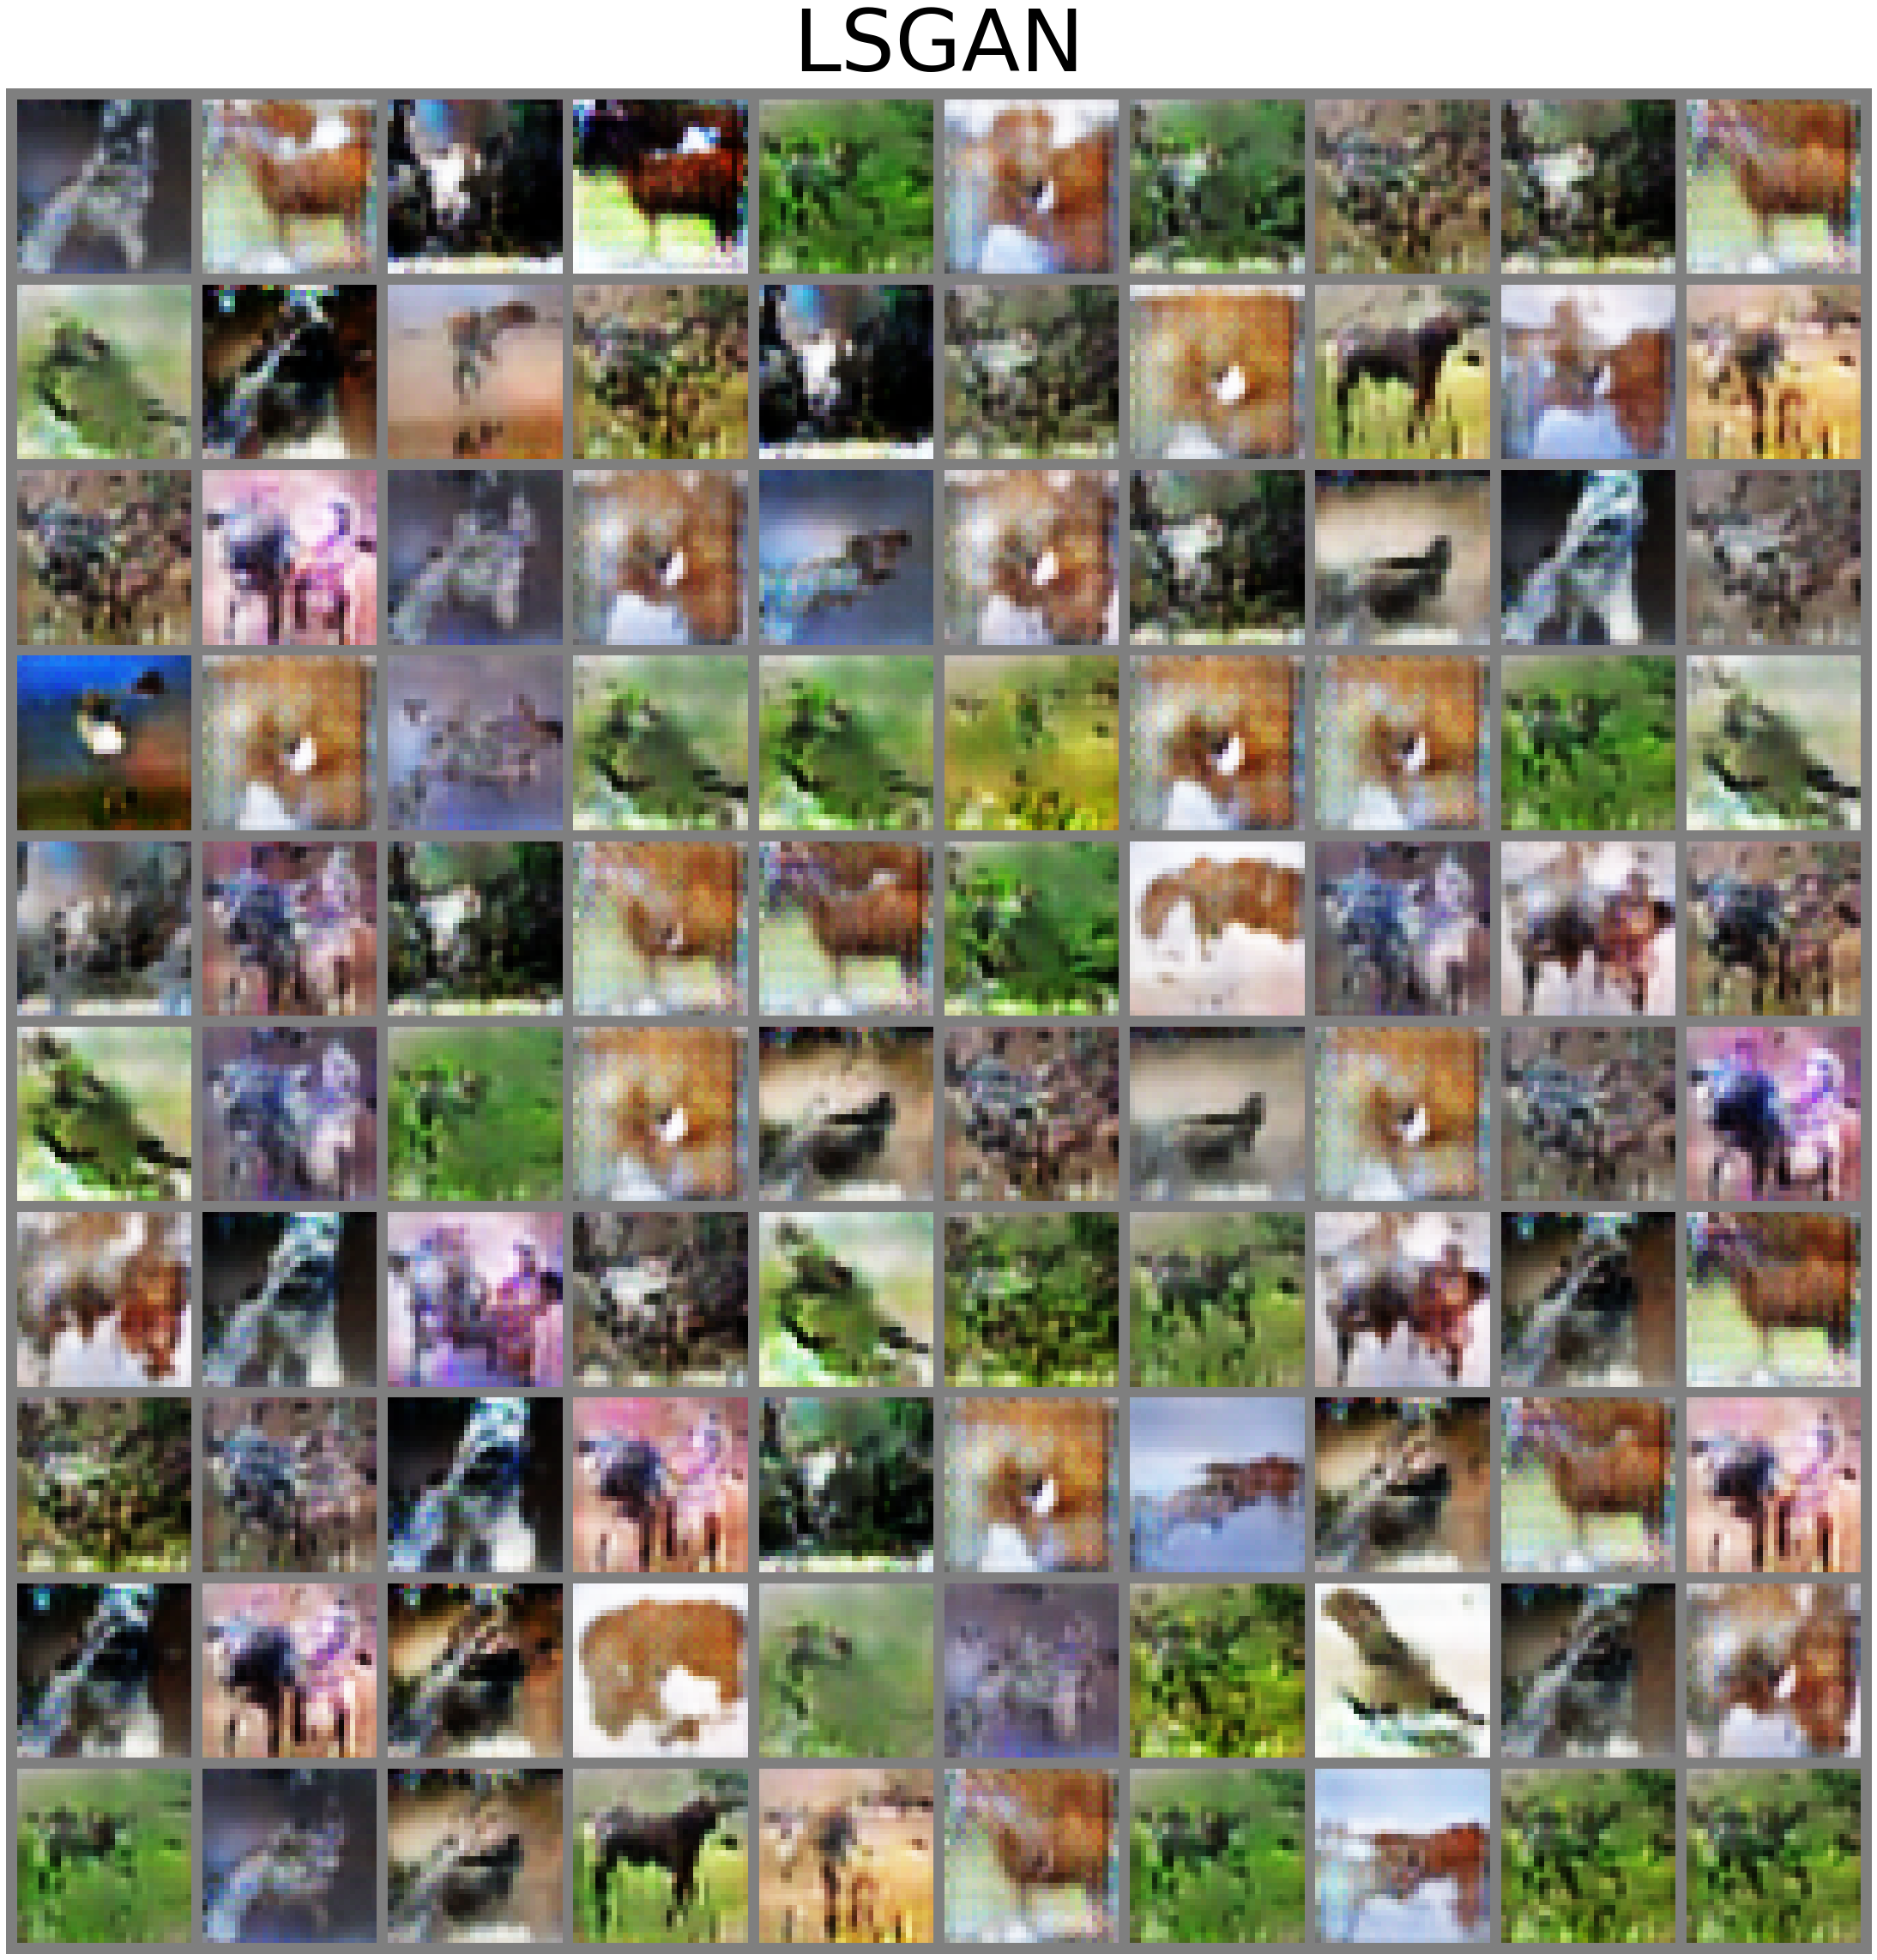

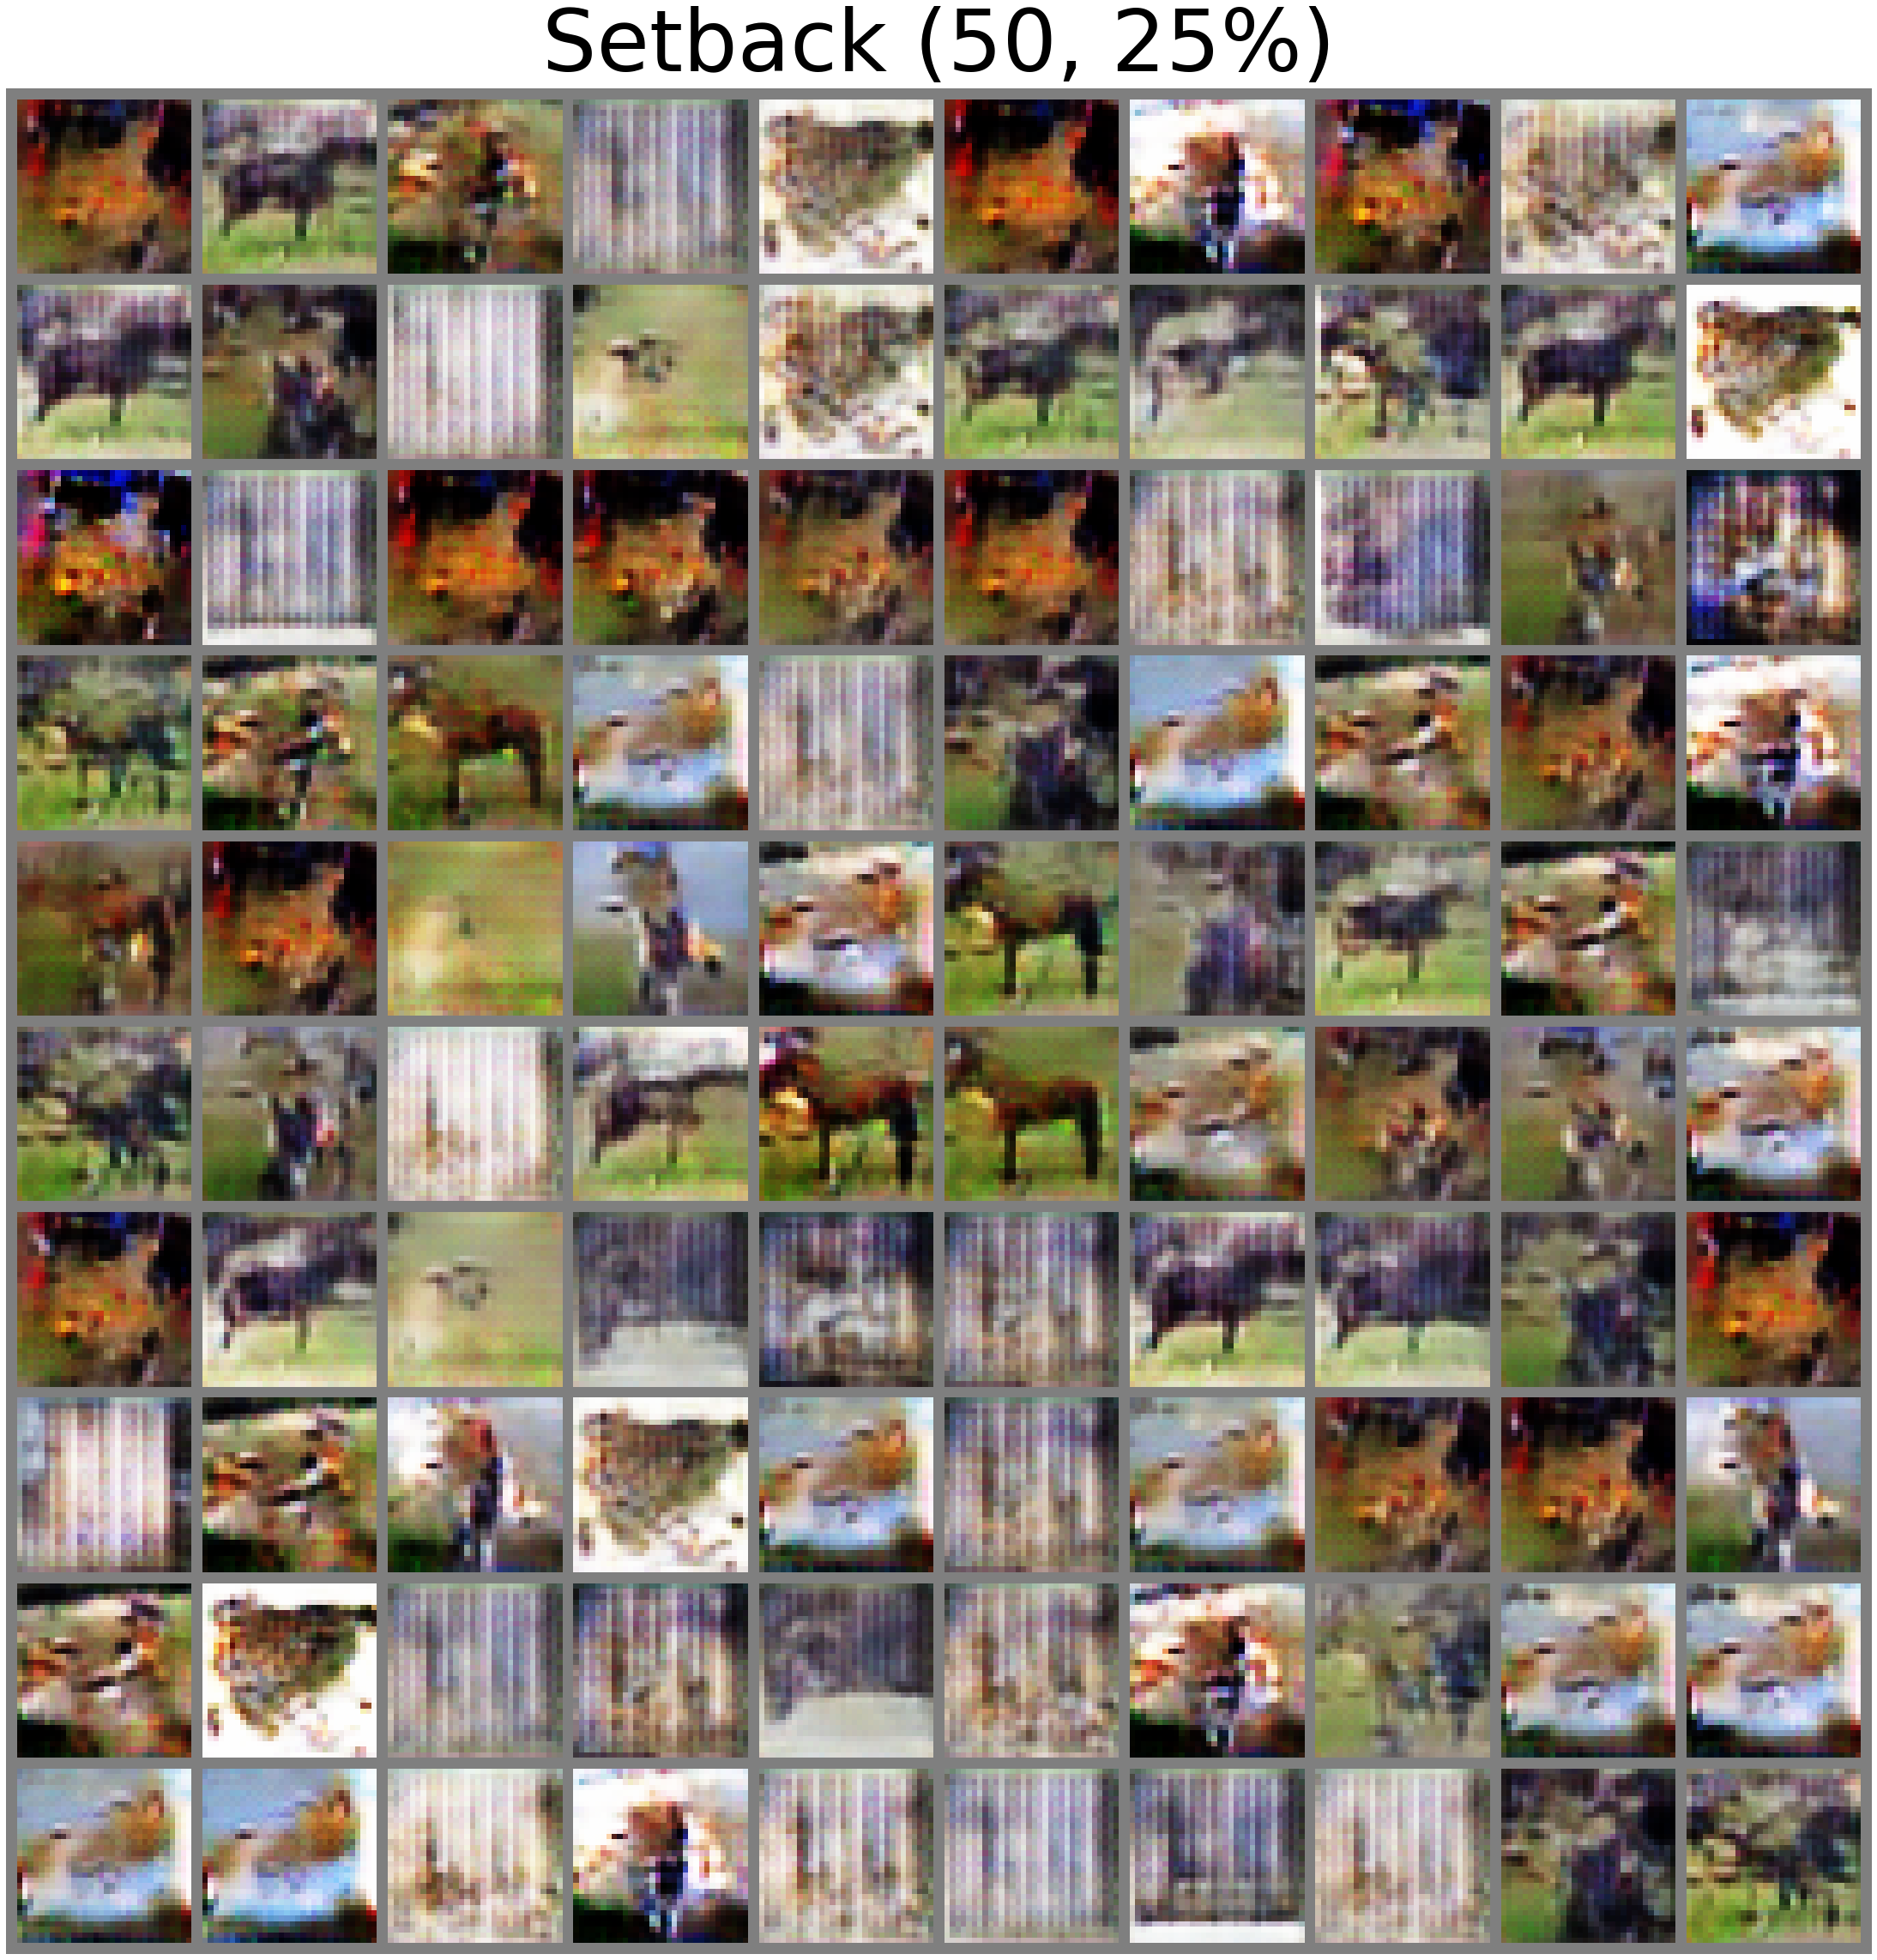

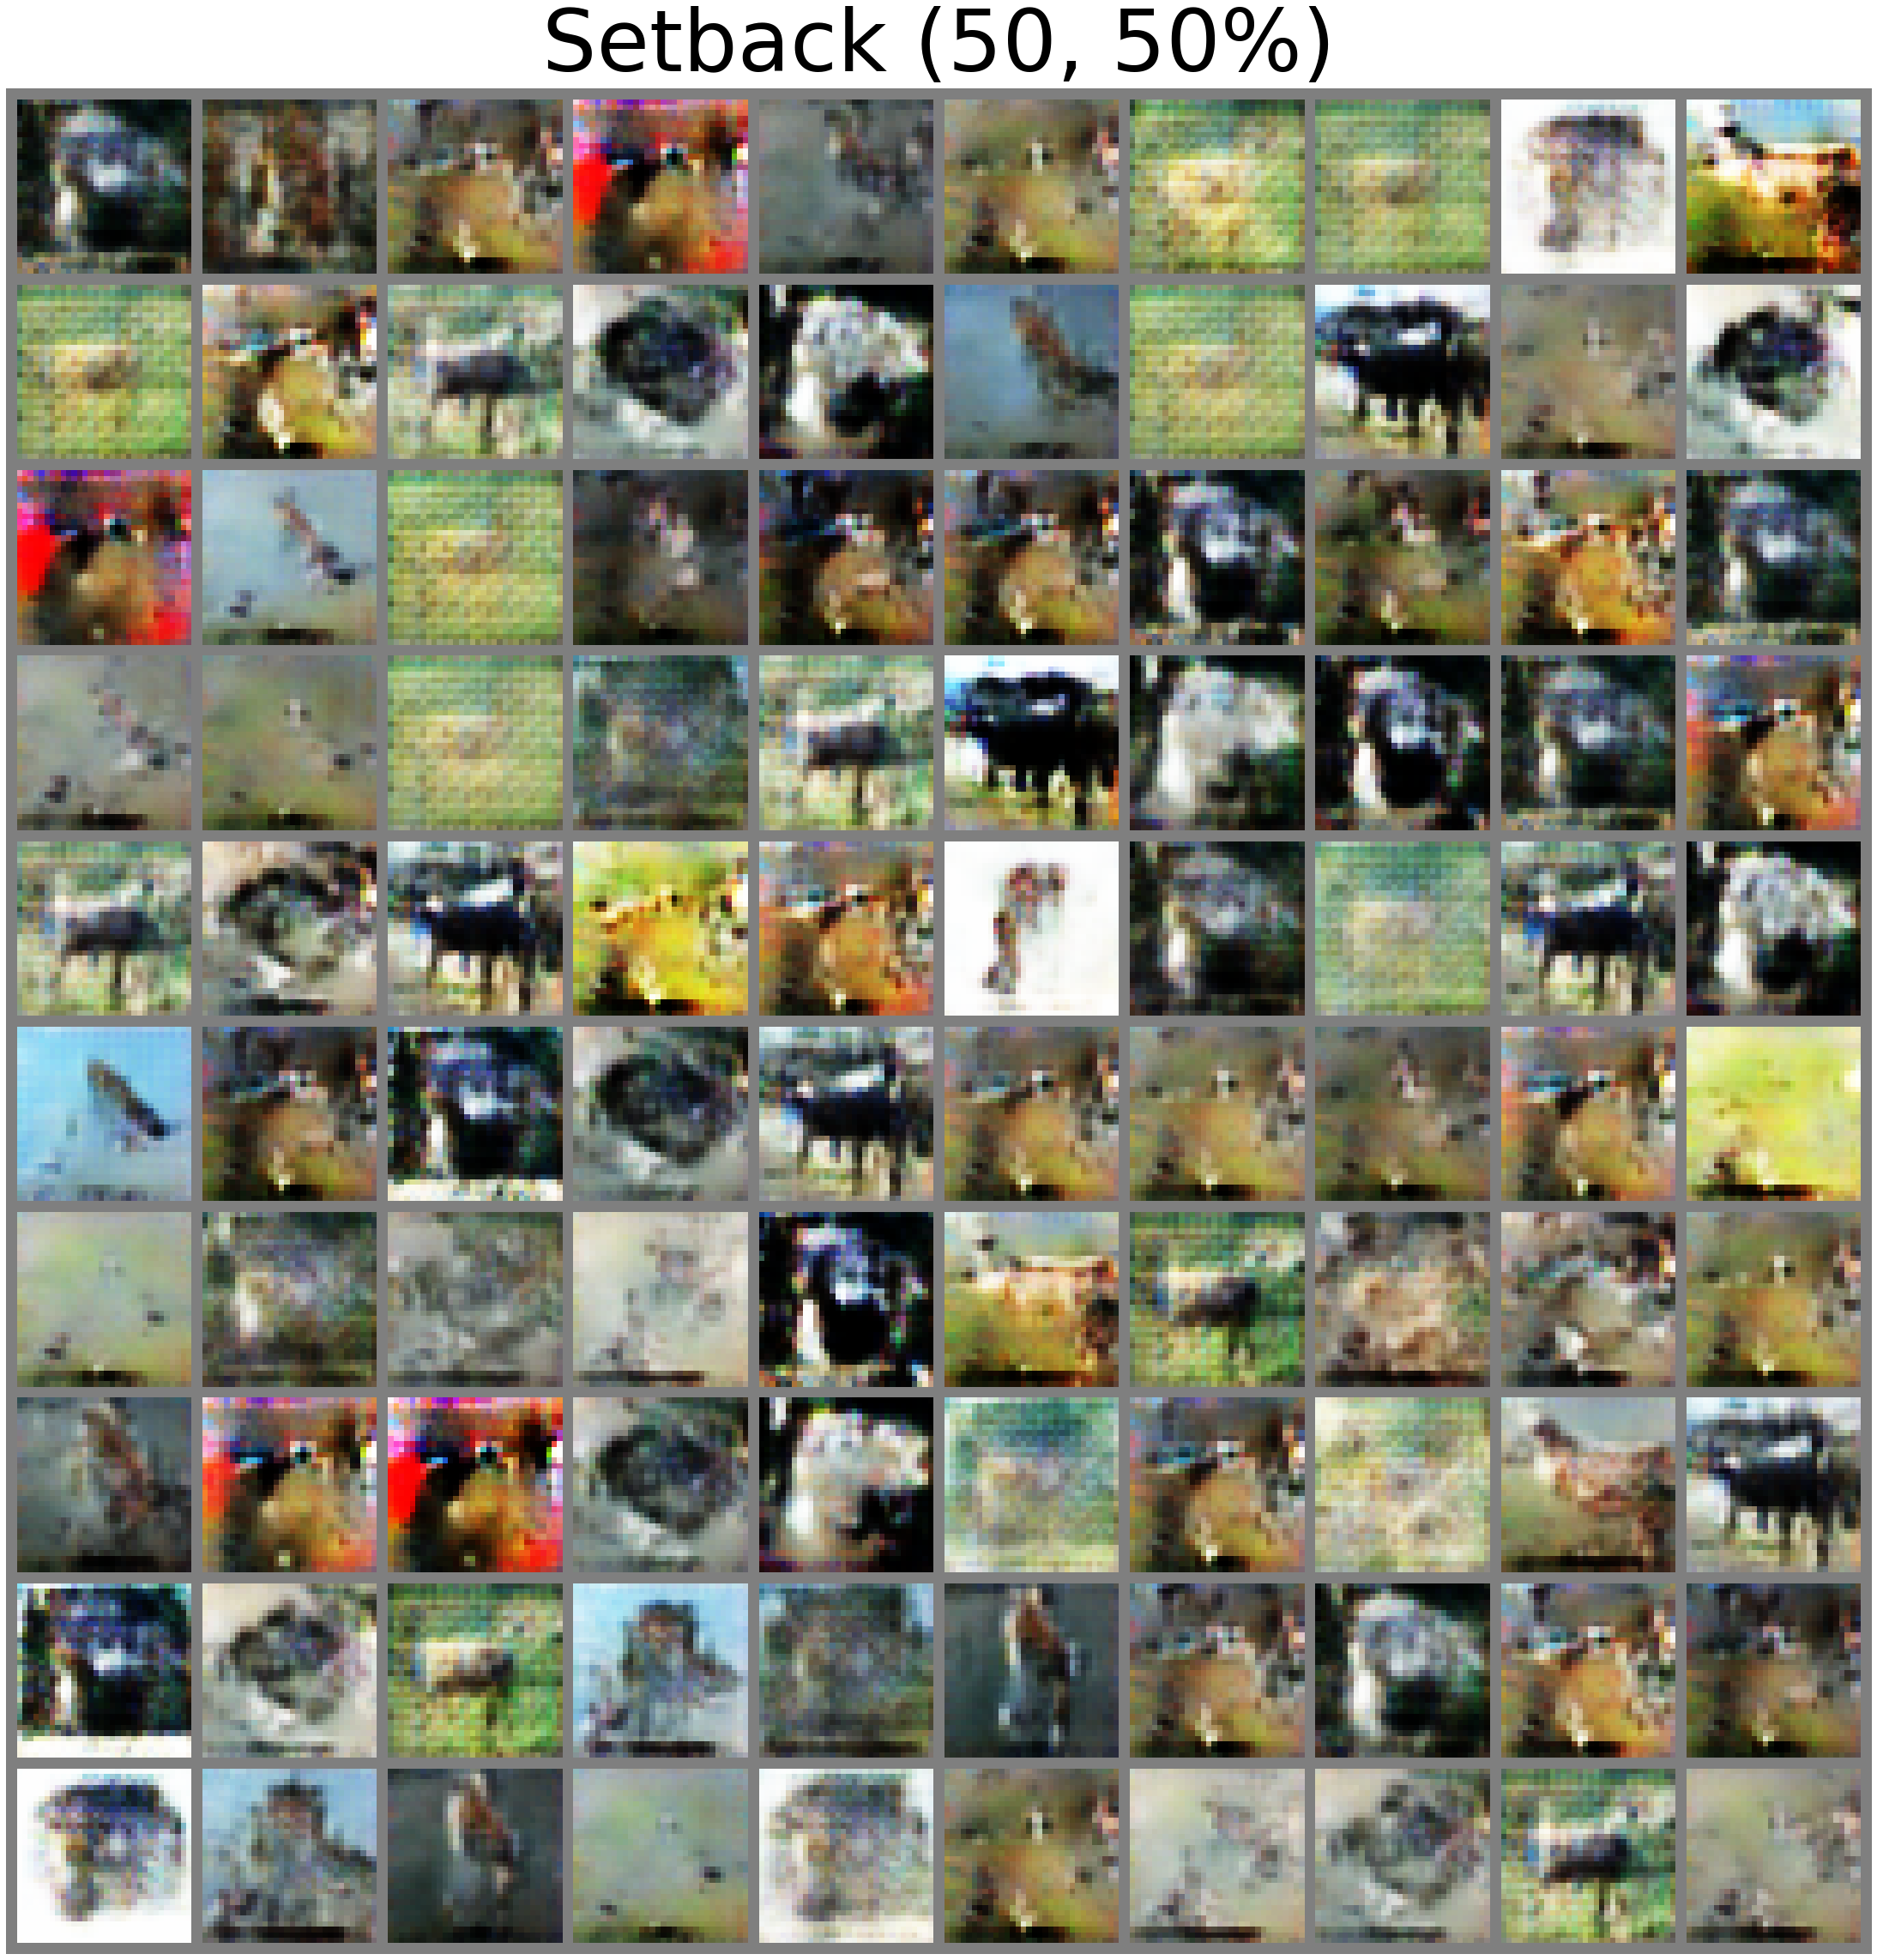

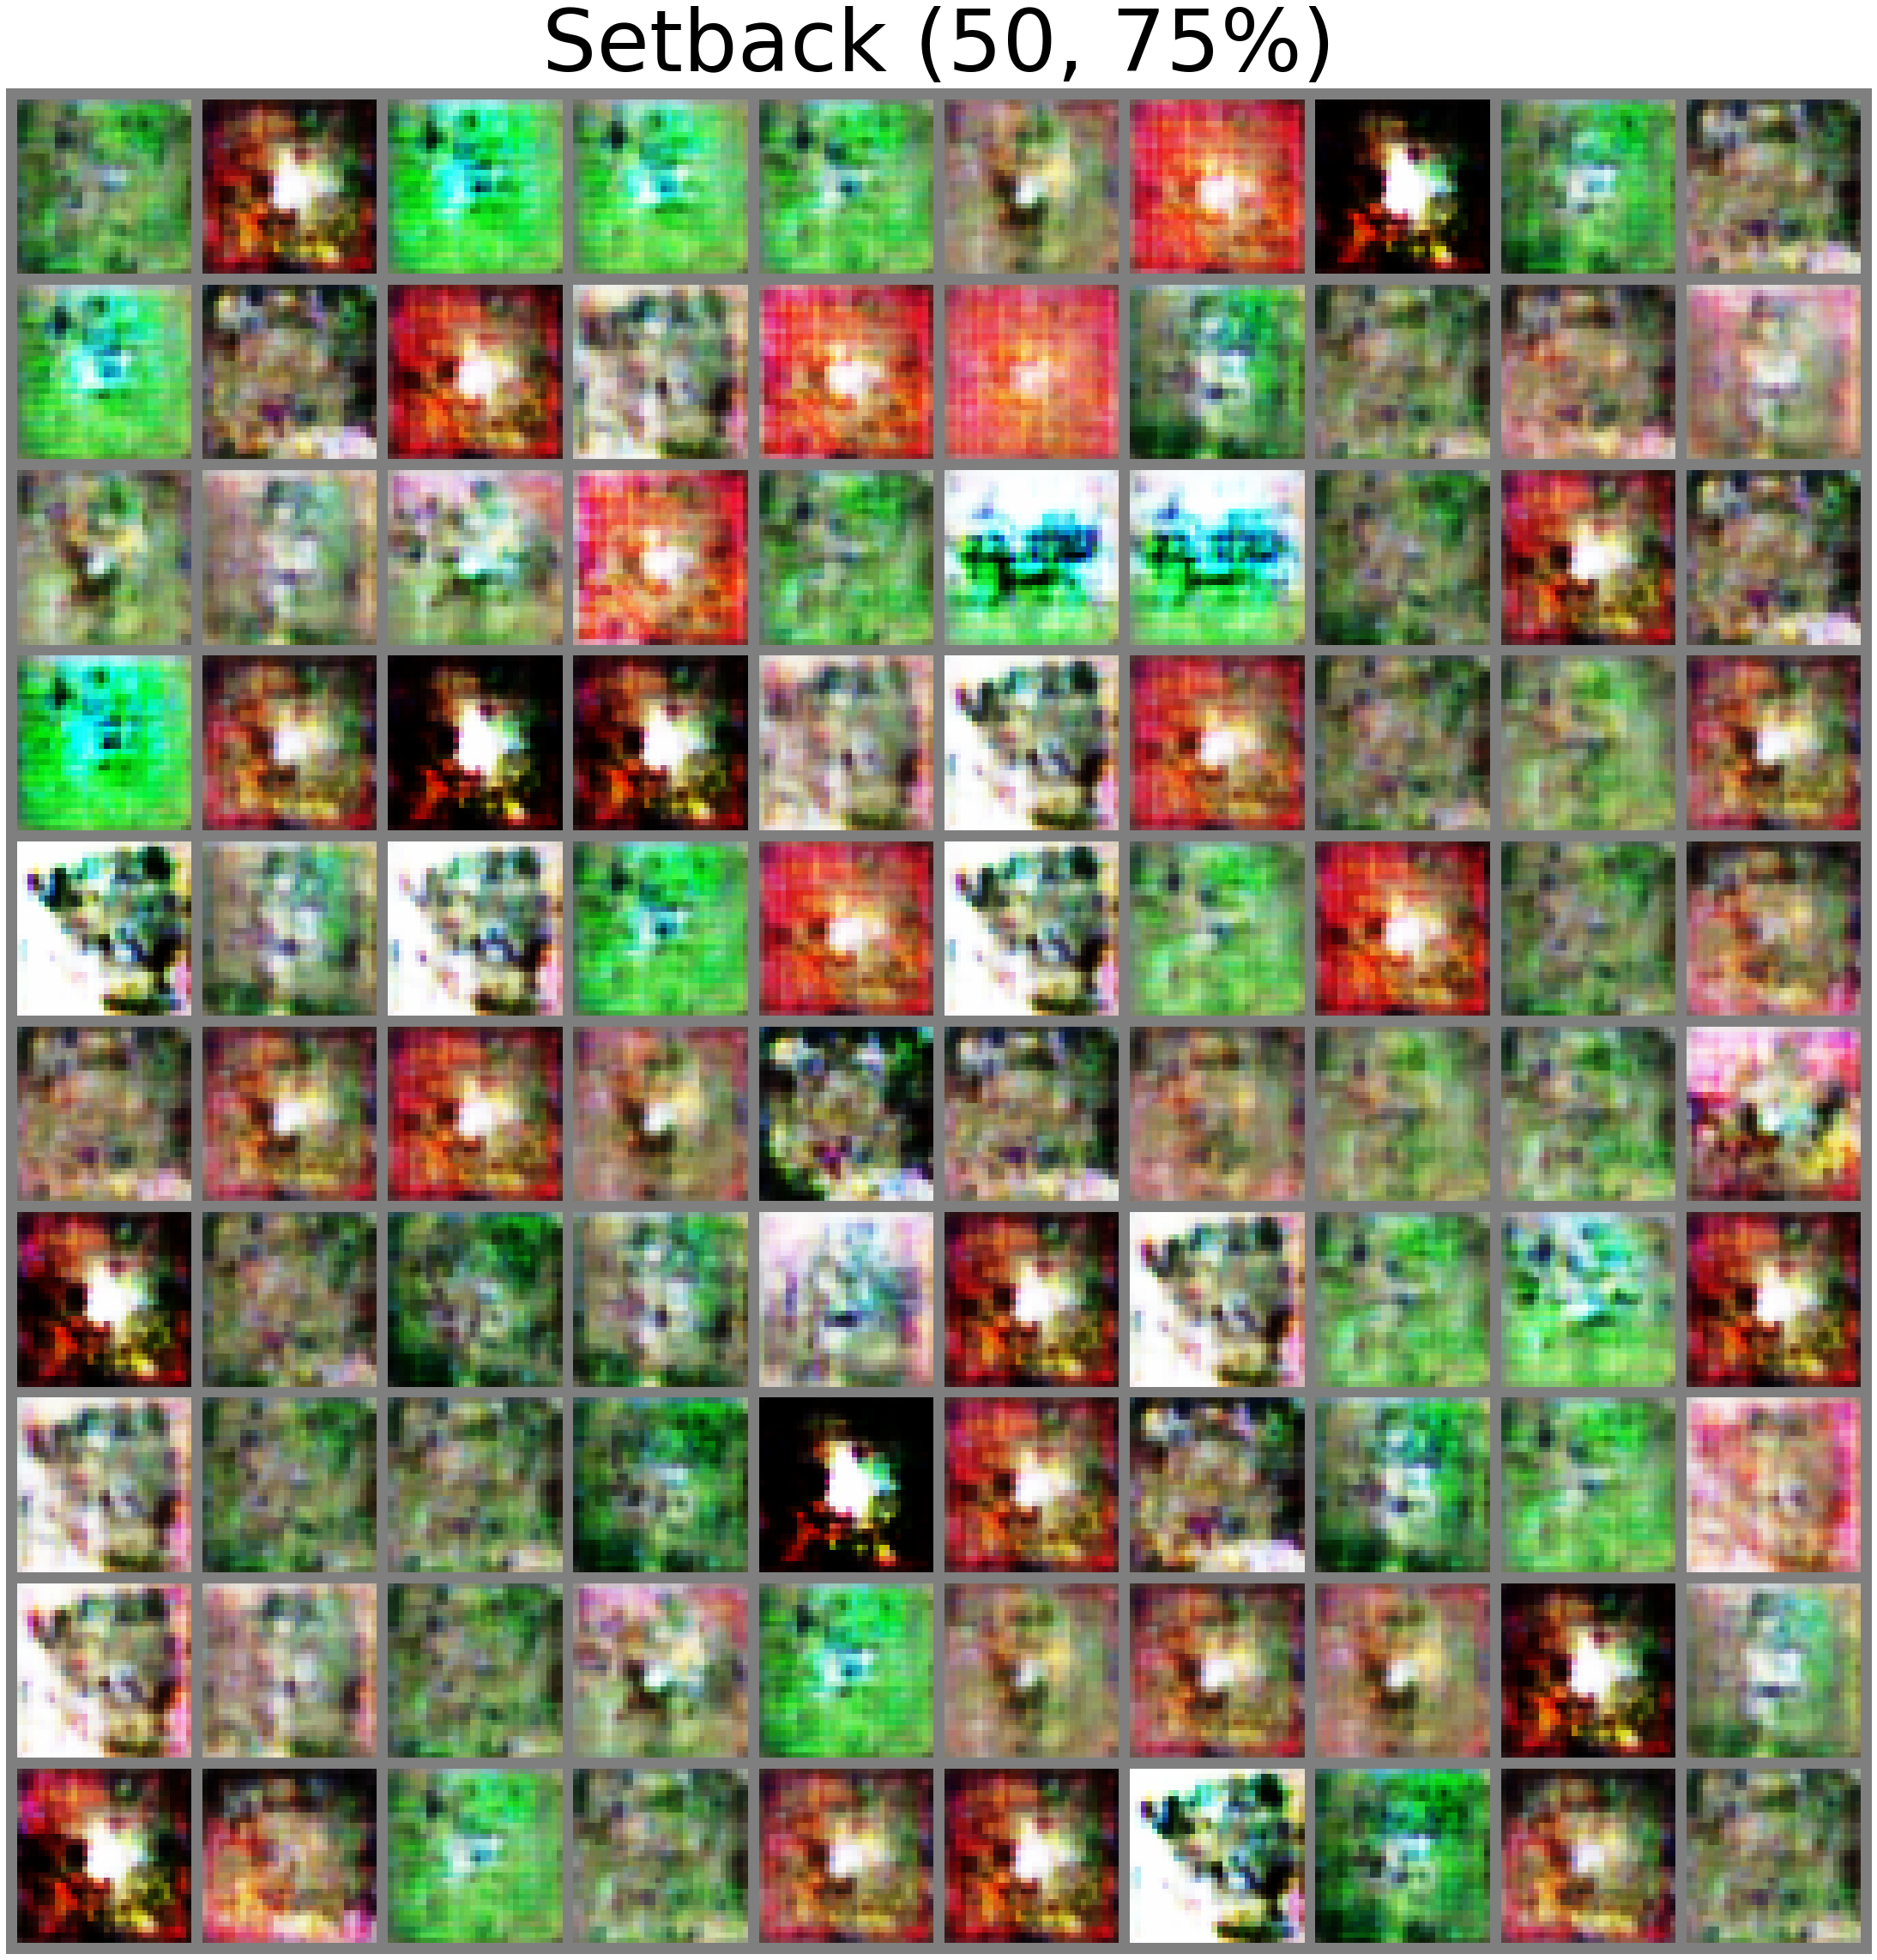

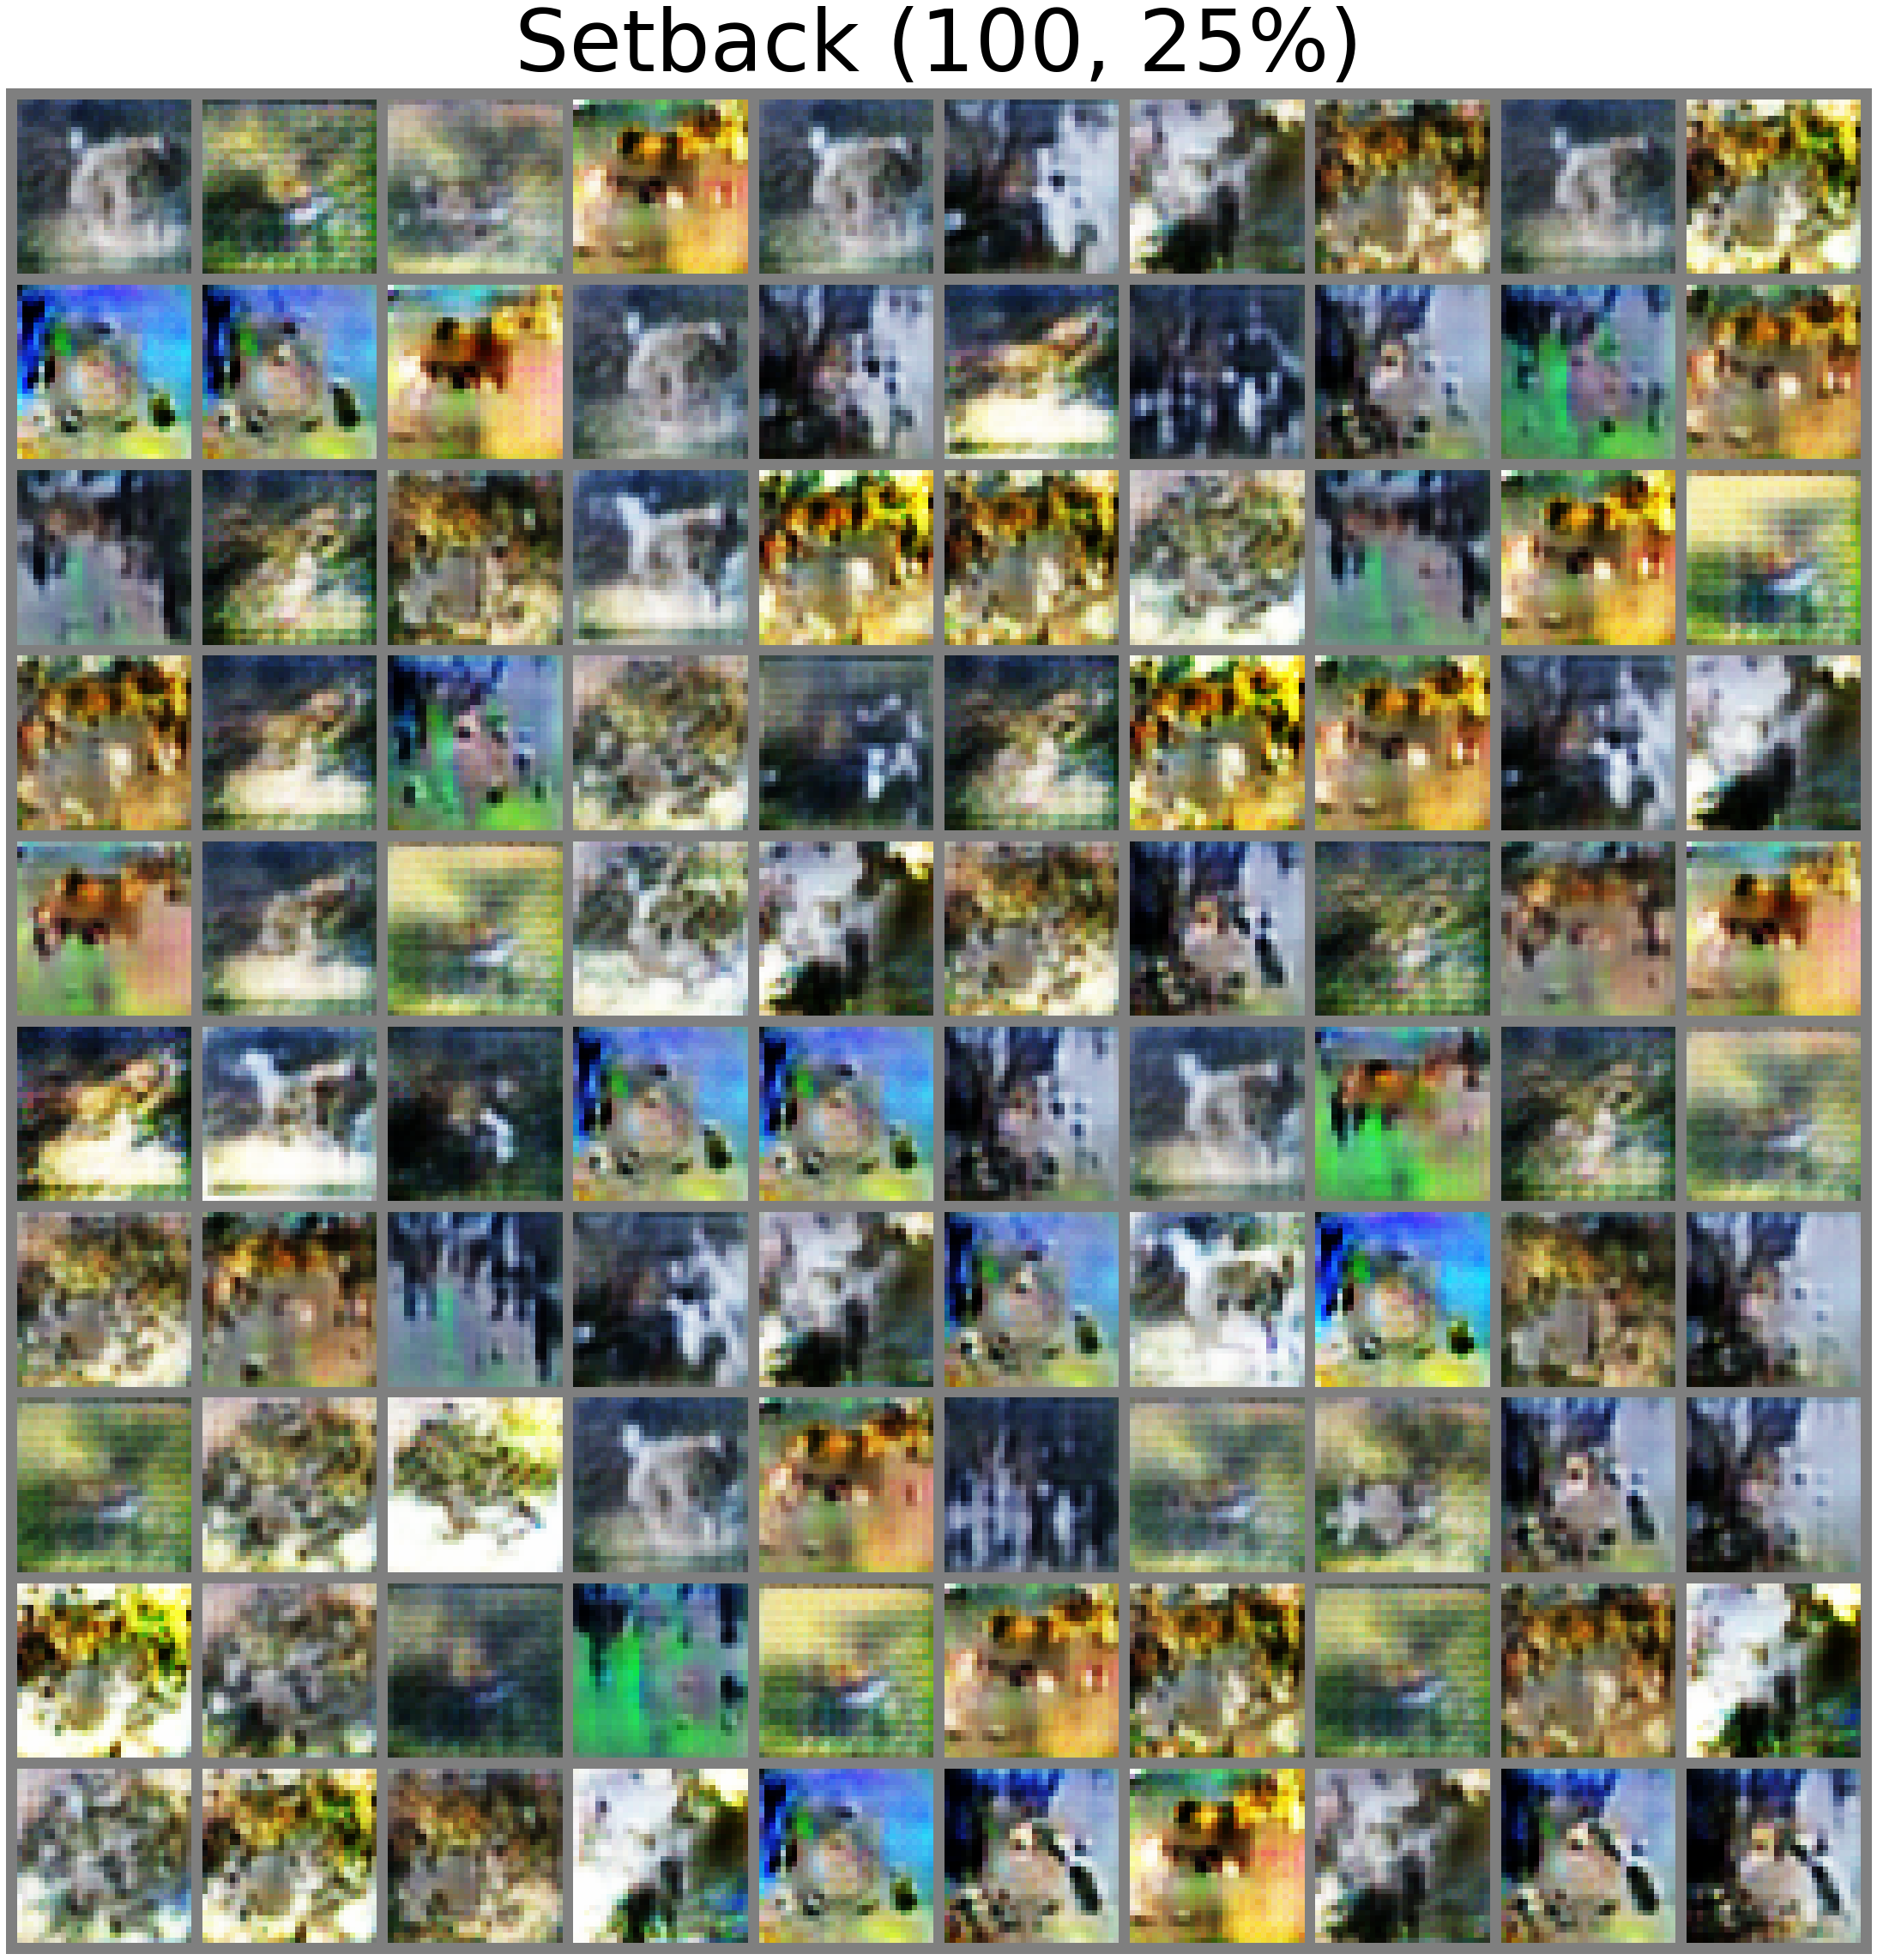

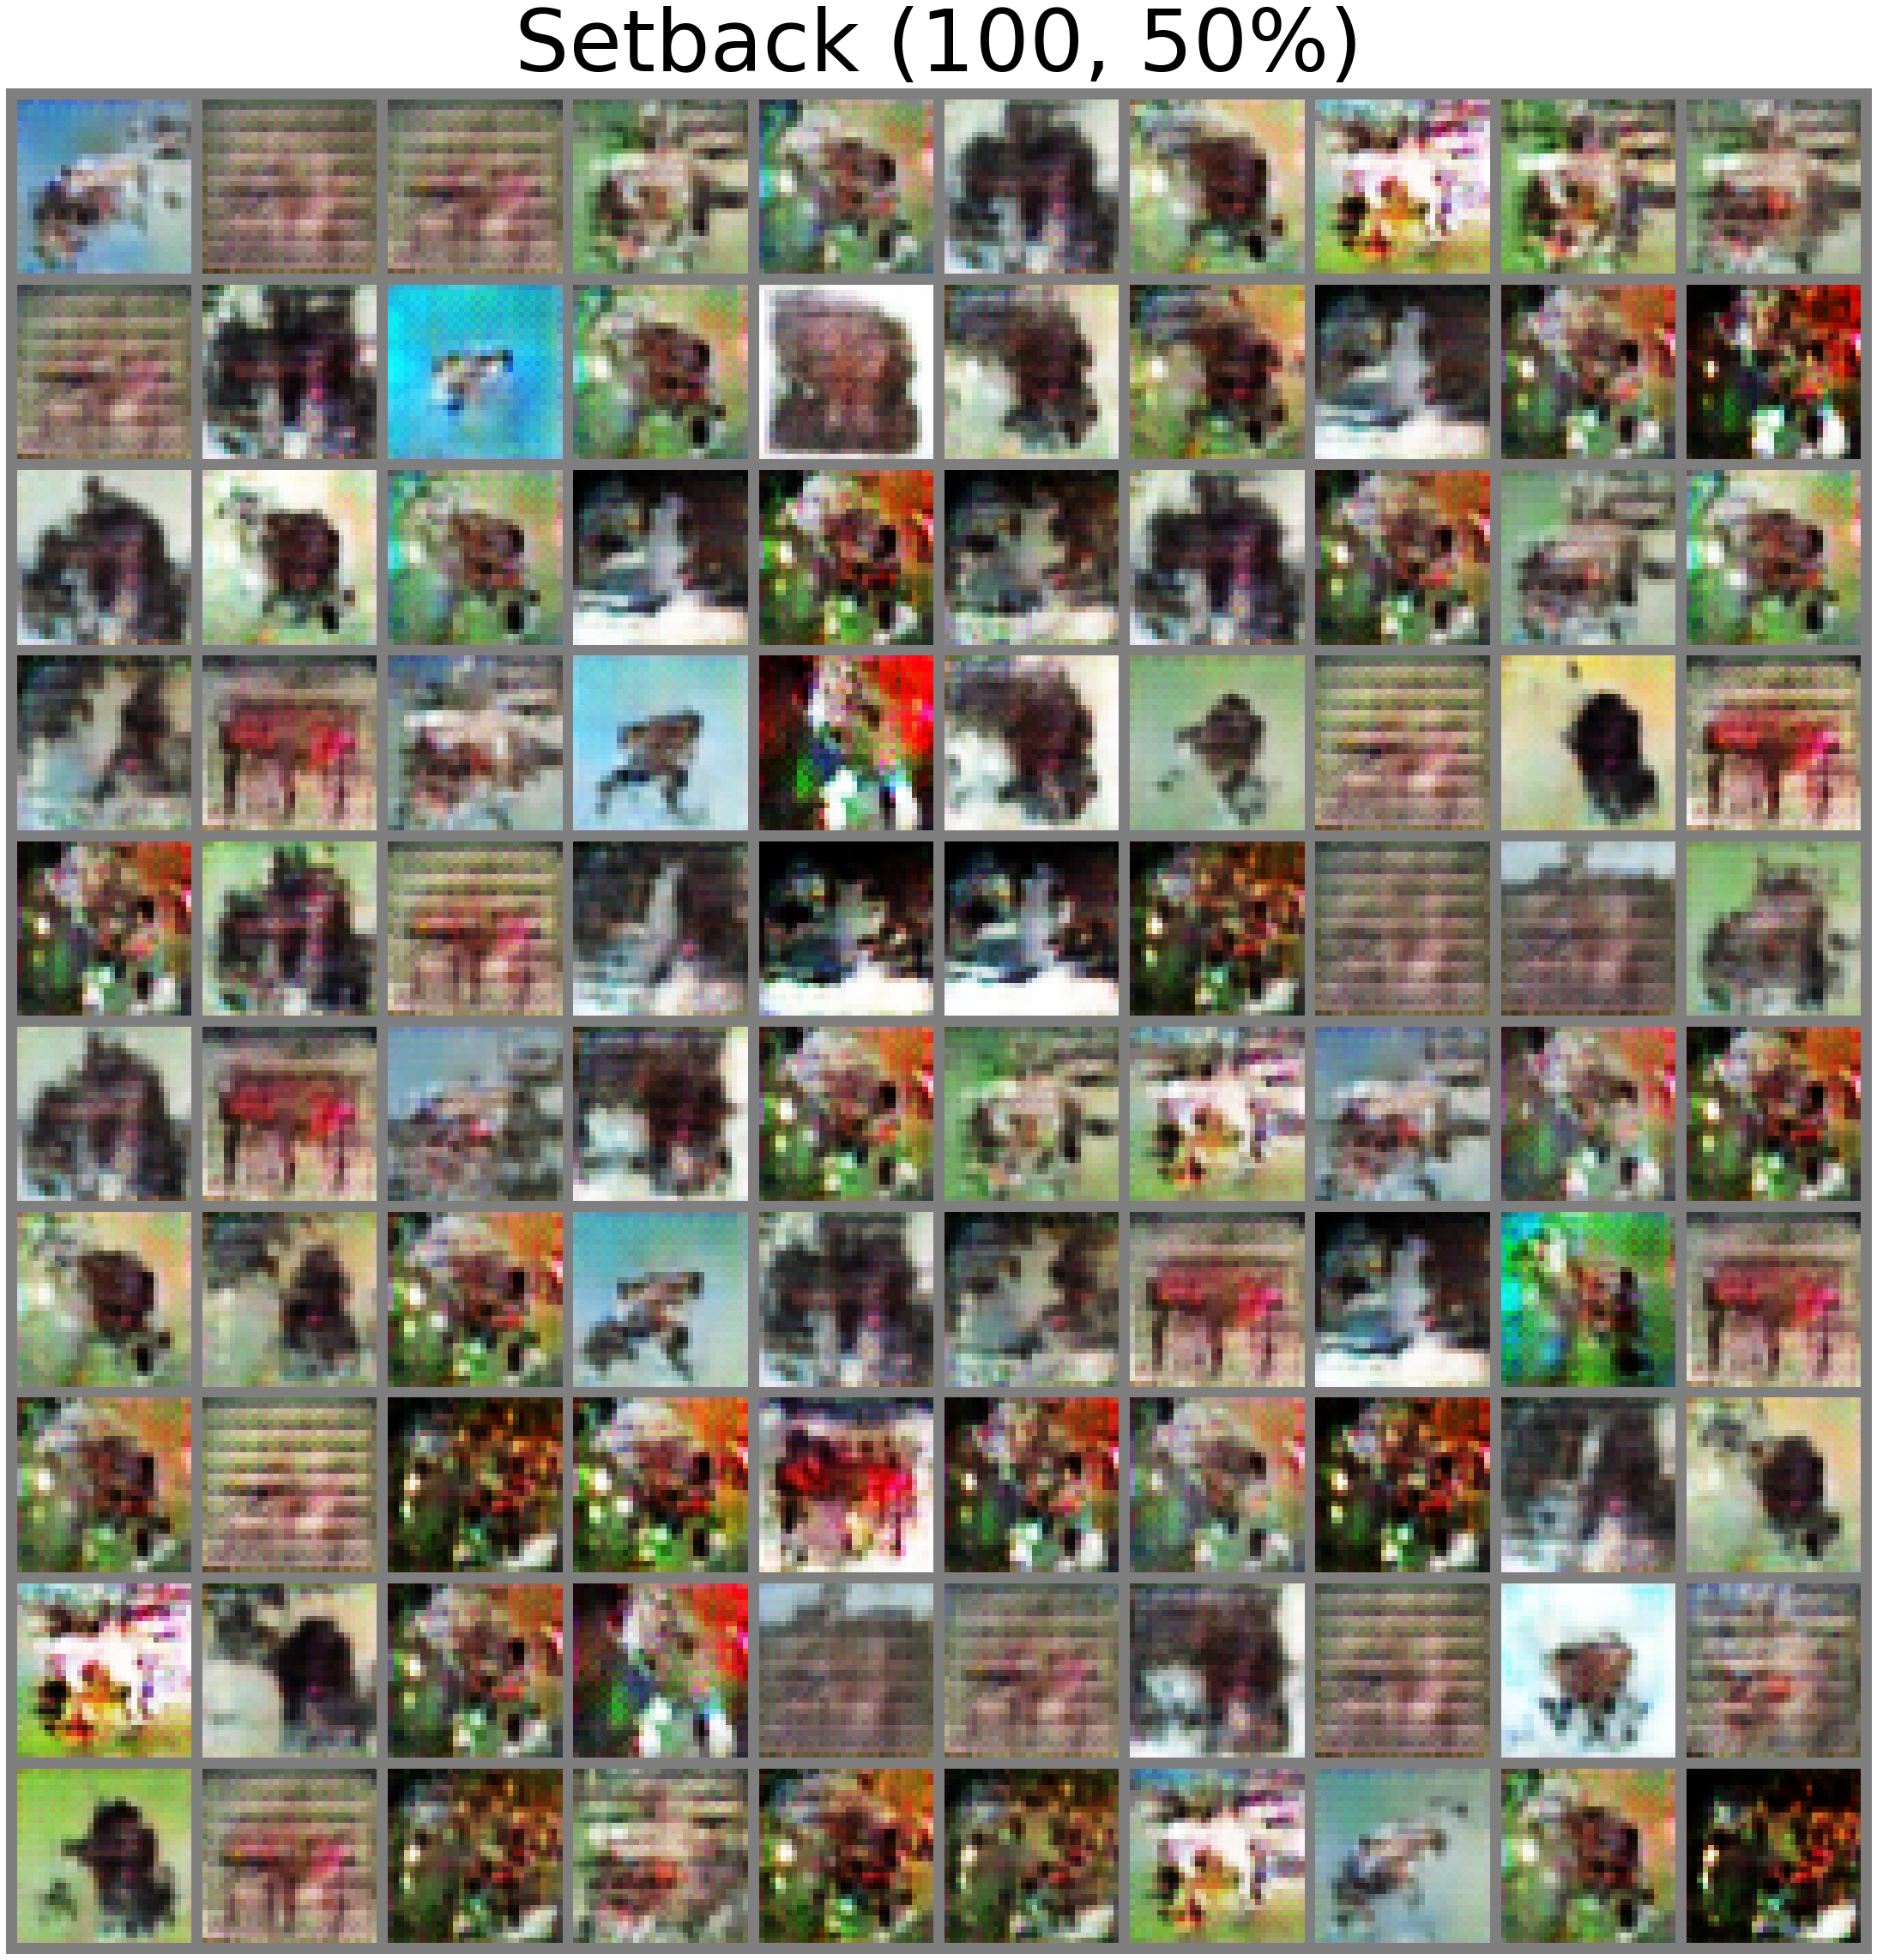

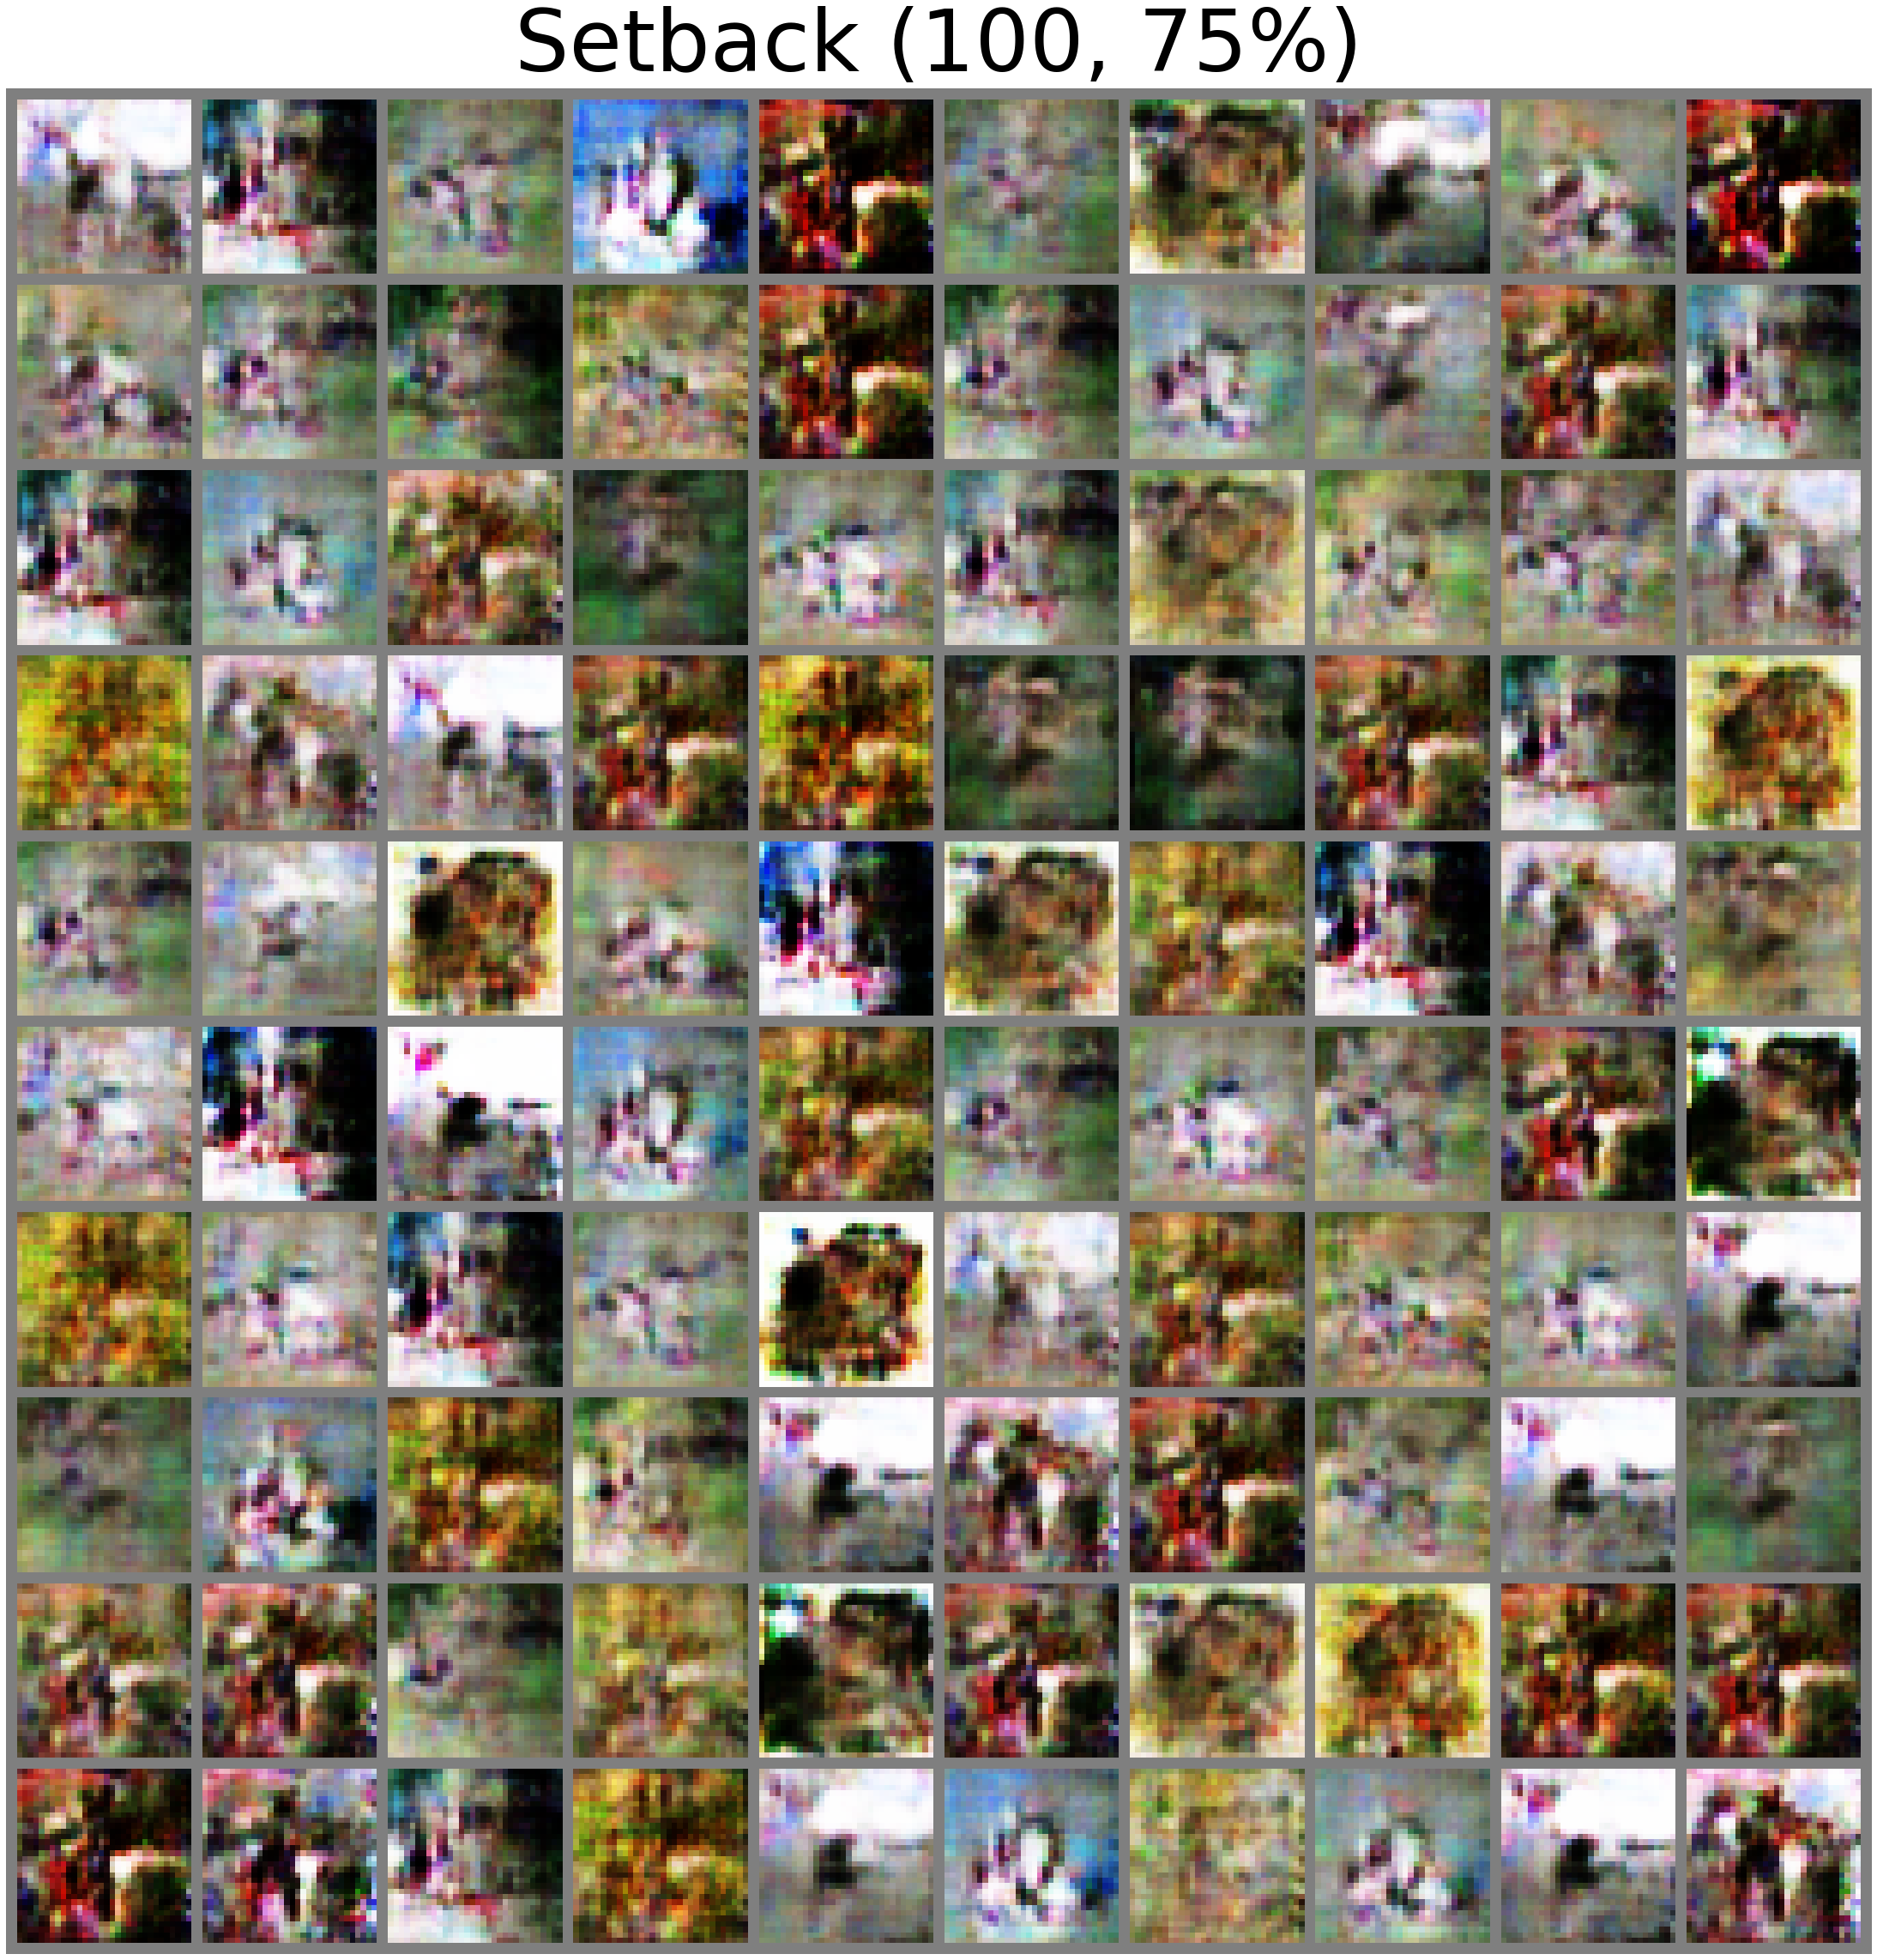

In [20]:
latent_dim = 100
random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (100, latent_dim)))).detach().cpu()
random_classes = Variable(Tensor(np.eye(6)[np.random.choice(6, 100)])).detach().cpu()
plot_100(gen_ls, random_latent_vectors=random_latent_vectors, title='LSGAN')
plot_100(gen_sb50_25, random_latent_vectors=random_latent_vectors, title=f'Setback (50, 25%)')
plot_100(gen_sb50_50, random_latent_vectors=random_latent_vectors, title=f'Setback (50, 50%)')
plot_100(gen_sb50_75, random_latent_vectors=random_latent_vectors, title=f'Setback (50, 75%)')
plot_100(gen_sb100_25, random_latent_vectors=random_latent_vectors, title=f'Setback (100, 25%)')
plot_100(gen_sb100_50, random_latent_vectors=random_latent_vectors, title=f'Setback (100, 50%)')
plot_100(gen_sb100_75, random_latent_vectors=random_latent_vectors, title=f'Setback (100, 75%)')


In [37]:
def plot_few(imgs, latent_dim=100, count=100, indicies=[0,1]):
    img = torchvision.utils.make_grid(imgs[indicies], padding=2, normalize=False, nrow=10)

    imshow(img)

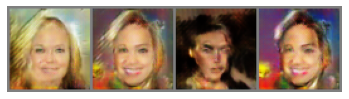

In [39]:
ims = gen_ls(random_latent_vectors)
plot_few(imgs=ims,indicies=[40,56,26,73])

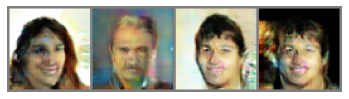

In [42]:
ims = gen_sb50_25(random_latent_vectors)
plot_few(imgs=ims,indicies=[76,39,48,91])

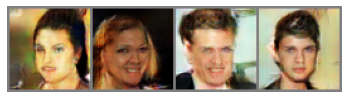

In [45]:
ims = gen_sb50_50(random_latent_vectors)
plot_few(imgs=ims,indicies=[45,25,3,99])

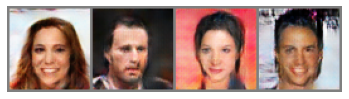

In [46]:
ims = gen_sb50_75(random_latent_vectors)
plot_few(imgs=ims,indicies=[19,71,92,67])

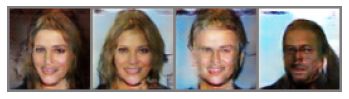

In [47]:
ims = gen_sb100_25(random_latent_vectors)
plot_few(imgs=ims,indicies=[90,93,39,95])

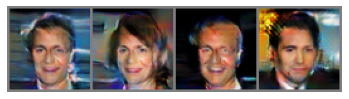

In [48]:
ims = gen_sb100_50(random_latent_vectors)
plot_few(imgs=ims,indicies=[46,73,72,50])

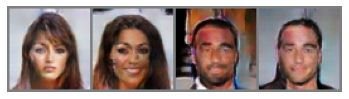

In [50]:
ims = gen_sb100_75(random_latent_vectors)
plot_few(imgs=ims,indicies=[90,95,94,73])

In [52]:
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding='same'),
        )
        self.fully_connected = nn.Sequential(
            nn.Linear(128*8*8, 128*8), nn.ReLU(),
            nn.Linear(128*8, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, n_classes),
        )
        
        self.classify =  nn.Softmax(dim=1)
        
        
    def forward(self, img):
        out = self.conv_blocks(img)
        out = torch.flatten(out, start_dim=1)
        out = self.fully_connected(out)
        out = self.classify(out)
        return out


In [53]:
def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
            print("but I don't want to take up memory on my GPU....")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    def get_pred(x):
        if resize:
            x = up(x)
        x = model1(x)
        return x.data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 8))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [54]:
random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (1000, latent_dim)))).detach().cpu()
generated_images = gen_sb100_50(random_latent_vectors)
checkpoint = torch.load( 'models/gan_models/face_classifier.pth')
model1 = Classifier(8).to(device)
model1.load_state_dict(checkpoint['state_dict'])
    
inception_score(generated_images)

(4.955189453852993, 0.0)

In [55]:
random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (10000, latent_dim)))).detach().cpu()

generated_images = gen_ls(random_latent_vectors)
print('ls',inception_score(generated_images)[0])

generated_images = gen_sb100_25(random_latent_vectors)
print('100 25',inception_score(generated_images)[0])

generated_images = gen_sb100_50(random_latent_vectors)
print('100 50 ',inception_score(generated_images)[0])

generated_images = gen_sb100_75(random_latent_vectors)
print('100 75',inception_score(generated_images)[0])

generated_images = gen_sb50_25(random_latent_vectors)
print('50 25',inception_score(generated_images)[0])

generated_images = gen_sb50_50(random_latent_vectors)
print('50 50 ',inception_score(generated_images)[0])

generated_images = gen_sb50_75(random_latent_vectors)
print('50 75',inception_score(generated_images)[0])

ls 5.284689349974733
100 25 5.4459168679515475
100 50  5.107890807588067
100 75 5.870593046445825
50 25 5.0151259836061035
50 50  5.549625357355393
50 75 6.075780552745505
